In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from neuralprophet import NeuralProphet
import plotly.graph_objects as go
import plotly.io as pio #some neural prophet images are made using plotly which provides interactive widgets(VERY COOL) but unfortunately in order to see them the entire code must be ran.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
#The warning above is a user warning in relation to the libraries working slower.
#The plotly warning arised after I reran the model. I spoke to Alanna about a fix.

We will begin by loading in the data that was created in the EDA notebook.

In [3]:
df = pd.read_csv('../data/NSRDB_to_model.csv',
                index_col = [0])

df.head()

,Wind_x,Wind_y,Dew Point,Cloud Type,Day Seasonality,Year Seasonality,Pressure,Relative Humidity,Temperature,Solar Zenith Angle,GHI
datetime,,,,,,,,,,,
2016-01-01 00:00:00,-0.635439,-0.735724,-5.0,0,-1.407890e-12,-0.002666,990,49.00,5.0,168.95,0
2016-01-01 00:30:00,-0.635439,-0.735724,-5.0,0,1.305262e-01,-0.002308,990,49.00,5.0,166.74,0
2016-01-01 01:00:00,-0.558814,-0.795487,-5.0,0,2.588190e-01,-0.001950,990,48.97,5.0,162.23,0
2016-01-01 01:30:00,-0.558814,-0.795487,-5.0,0,3.826834e-01,-0.001591,990,48.97,5.0,156.74,0
2016-01-01 02:00:00,-0.479173,-0.851865,-5.0,0,5.000000e-01,-0.001233,990,48.98,5.0,150.83,0




---
# Data Pre-Processing
#### We will first look at the trends by creating features below. These are based on time frequencies.

The features below were created to look at a pairplot of the GHI by the Minute, Hour, Day(of the week), Month, and Year.

In [4]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['datetime'] = pd.to_datetime(df.index)  # Convert index to datetime type
    df['Hour'] = df['datetime'].dt.hour
    df['Day'] = df['datetime'].dt.dayofweek #Monday = 0 and Sunday = 6.
    df['Minute'] = df['datetime'].dt.quarter
    df['Month'] = df['datetime'].dt.month
    df['Year'] = df['datetime'].dt.year
    
    X = df[['Hour', 'Day', 'Month', 'Year', 'Minute']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='GHI')

features_and_target = pd.concat([X, y], axis=1)

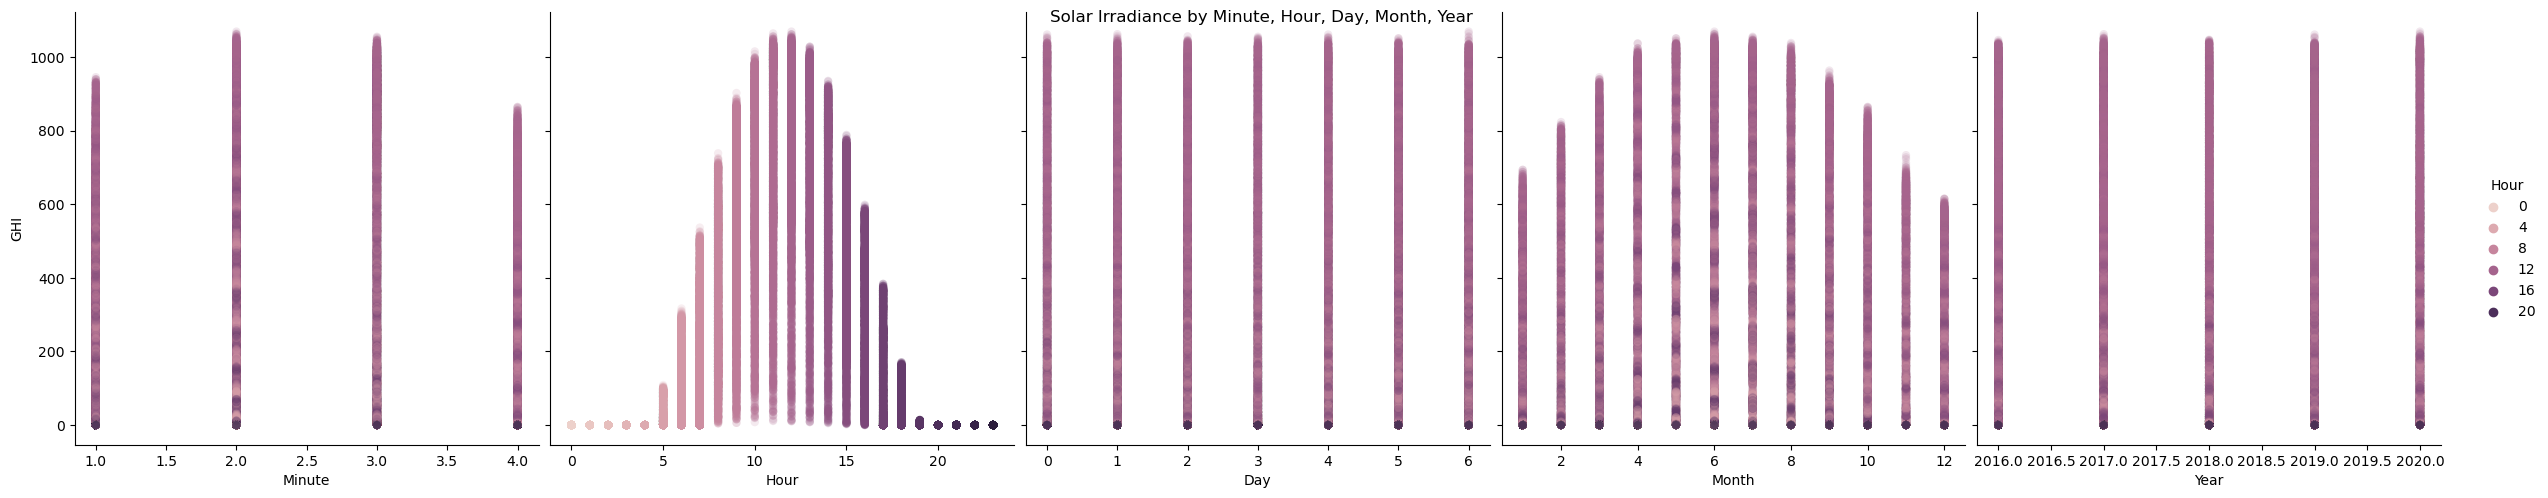

In [5]:
sns.pairplot(features_and_target.dropna(),
             hue='Hour',
             x_vars=['Minute', 'Hour','Day',
                     'Month','Year'],
             y_vars='GHI',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Solar Irradiance by Minute, Hour, Day, Month, Year')
plt.show()

Based on the image we can see that the midday hours have the highest GHI and the late spring and summer months have the highest GHI.

### Train-Test Split

Below we will create a date split for our testing and training data.
- The testing data will be composed of the datetime beginning October 31, 2020 and ending in December 31, 2020.
- the training data will be composed of January 1, 2016 to September 30, 2020.

In [6]:
date_split = '2020-10-01'
train = df.loc[df.index <= date_split].copy()
test = df.loc[df.index > date_split].copy()

Let's look at the train/test split of the data in order to visually see how it looks.

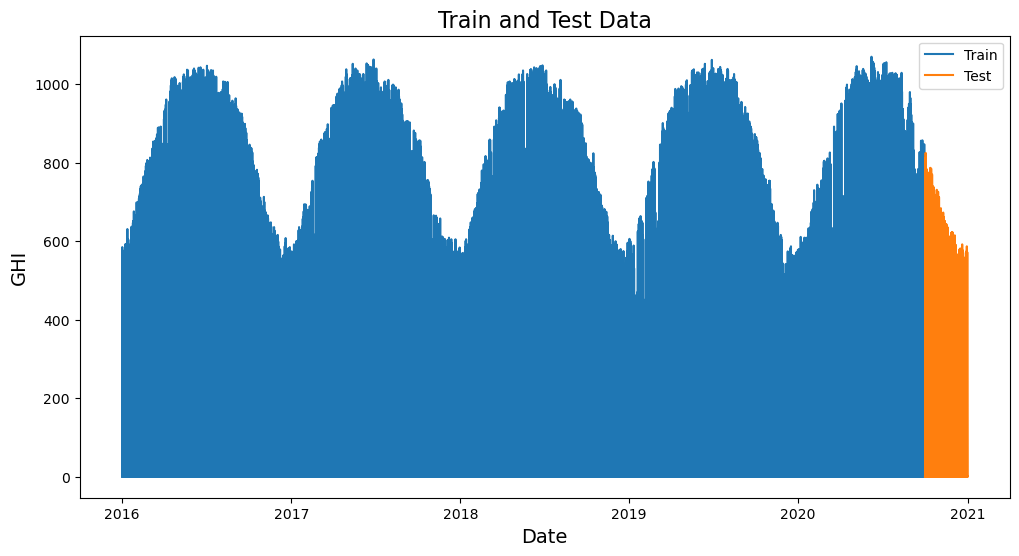

In [7]:
# Plot train and test data
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(train.index), train['GHI'], label='Train')
plt.plot(pd.to_datetime(test.index), test['GHI'], label='Test')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('GHI', fontsize = 14)
plt.title('Train and Test Data', fontsize = 16)
plt.legend()
plt.show()

**The image above is to visualize the train and testing data**

---
# Neural Prophet Model

**In order for a neural prophet model to work I need to have a column titled ds for datetime(also in datetime type) and a column labeled y for what we are trying to predict, for this project it will be the GHI(Global Horizontal Irradiation).**

- Here we are setting the test and training data to match the Neural Prophet model format. This is using the precious date split data that was created.

In [8]:
ghi_train = train.reset_index().rename(columns={'datetime': 'ds', 'GHI': 'y'})
ghi_train['ds'] = pd.to_datetime(ghi_train['ds'])
ghi_train = ghi_train[['ds', 'y']].copy()

In [9]:
ghi_test = test.reset_index().rename(columns={'datetime': 'ds', 'GHI': 'y'})
ghi_test['ds'] = pd.to_datetime(ghi_test['ds'])
ghi_test = ghi_test[['ds', 'y']].copy()

*Setting up and fitting a neural prophet model with a batch_size of 64(default), and 60 epochs(default).  The time frequency is set to 30T(30 minute time intervals) which matches the ds column in the data. I used the default 60 epochs because Neural Prophet does not have a stopping functinality.*

In [10]:
model = NeuralProphet()
model.fit(ghi_train)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as 30T
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 60
Missing logger folder: /Users/martijndevries/GA_DSI/projects/solar-intensity-forecast/code/lightning_logs


Finding best initial lr:   0%|          | 0/273 [00:00<?, ?it/s]

2023-05-21 09:07:20.805531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,548.287415,673.274597,0.205385,0.0,0
1,148.607941,185.822861,0.018066,0.0,1
2,90.681099,122.023544,0.007063,0.0,2
3,90.756866,122.523293,0.007120,0.0,3
4,91.403763,123.325943,0.007225,0.0,4
5,92.271500,124.453194,0.007362,0.0,5
6,93.046410,125.621475,0.007485,0.0,6
7,94.276711,127.055168,0.007668,0.0,7
8,95.007545,128.183258,0.007801,0.0,8
9,95.962997,129.575150,0.007957,0.0,9


---
#### Test Forecast

Below we will take the testing forecast and look at the Root Mean Squared Error and the Mean Absolute Error which are the evaluation metrics we will look at for model performance.

In [11]:
ghi_forecast = model.predict(df = ghi_test)
ghi_forecast.head()

INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.977% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30T
INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.977% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30T


Predicting: 1302it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly,season_daily
0,2020-10-01 00:00:00,0,9.380030,237.160477,2.935832,-0.441551,-230.274734
1,2020-10-01 00:30:00,0,9.271415,237.161469,2.915612,-0.424961,-230.380722
2,2020-10-01 01:00:00,0,9.090784,237.162445,2.895386,-0.404826,-230.562210
3,2020-10-01 01:30:00,0,9.264875,237.163406,2.875154,-0.381048,-230.392639
4,2020-10-01 02:00:00,0,9.918743,237.164398,2.854915,-0.353538,-229.747025


In [12]:
y_pred_test = ghi_forecast['yhat1']
y_true_test = ghi_test['y']

In [13]:
rmse_test = mean_squared_error(y_true=y_true_test, y_pred=y_pred_test, squared = False)
mae_test = mean_absolute_error(y_true=y_true_test, y_pred=y_pred_test)

print("Root Mean Squared Error (Test):", rmse_test)
print("Mean Absolute Error (Test):", mae_test)

Root Mean Squared Error (Test): 107.4179538146686
Mean Absolute Error (Test): 76.45036973215073


---
#### Train Forecast

Below we will look at the Training Root Mean Squared Error and the Mean Absolute Error which we will use for the overall comparison of the model.

In [14]:
train_forecast = model.predict(df=ghi_train)
train_forecast.head()

INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30T
INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30T


Predicting: 1302it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly,season_daily
0,2016-01-01 00:00:00,0,-101.817924,236.610504,-112.149857,3.996172,-230.274734
1,2016-01-01 00:30:00,0,-101.812706,236.609818,-112.152817,4.111015,-230.380722
2,2016-01-01 01:00:00,0,-101.886177,236.609085,-112.155754,4.222708,-230.562210
3,2016-01-01 01:30:00,0,-101.611923,236.608383,-112.158646,4.330968,-230.392639
4,2016-01-01 02:00:00,0,-100.865364,236.607666,-112.161499,4.435514,-229.747025


In [15]:
y_pred_train = train_forecast['yhat1']
y_true_train = ghi_train['y']

In [16]:
rmse_train = mean_squared_error(y_true=y_true_train, y_pred=y_pred_train, squared = False)
mae_train = mean_absolute_error(y_true=y_true_train, y_pred=y_pred_train)

print("Root Mean Squared Error (Training):", rmse_train)
print("Mean Absolute Error (Training):", mae_train)

Root Mean Squared Error (Training): 122.65131592293025
Mean Absolute Error (Training): 89.99042557474695


---
## Overall Evaluation

In [17]:
print("Root Mean Squared Error (Test):", rmse_test)
print("Root Mean Squared Error (Training):", rmse_train)

Root Mean Squared Error (Test): 107.4179538146686
Root Mean Squared Error (Training): 122.65131592293025


In [18]:
print("Mean Absolute Error (Test):", mae_test)
print("Mean Absolute Error (Training):", mae_train)

Mean Absolute Error (Test): 76.45036973215073
Mean Absolute Error (Training): 89.99042557474695


Overall we can say that the model is performing reasonably well.

We opted out of using R2 Score to evaluate the model. Refer to [link](https://stats.stackexchange.com/questions/101546/what-is-the-problem-with-using-r-squared-in-time-series-models)

---
## Prediction Visuals

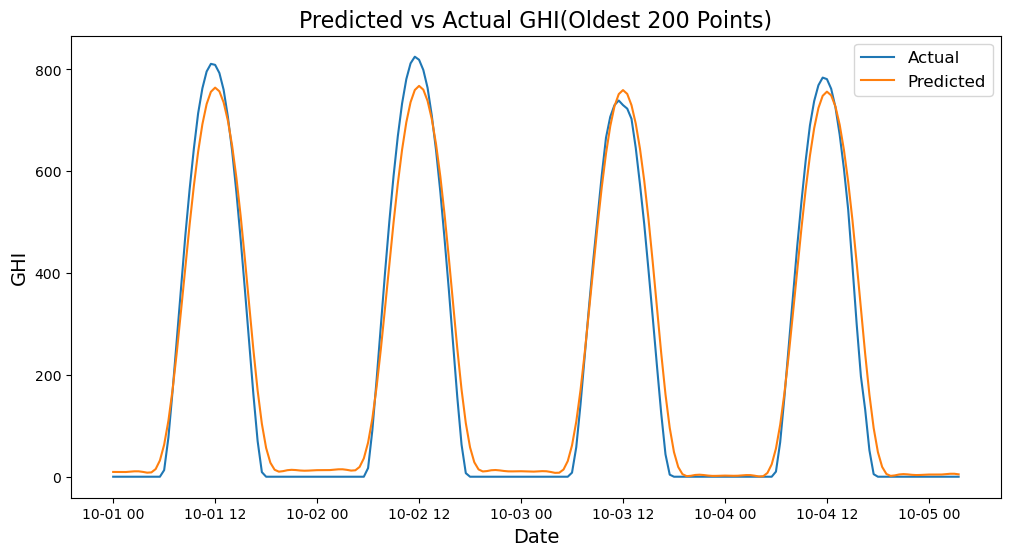

In [19]:
f, ax = plt.subplots(1, figsize=(12, 6))
ax.plot(ghi_test['ds'][0:200], ghi_test['y'][0:200], label='Actual')
ax.plot(ghi_forecast['ds'][0:200], ghi_forecast['yhat1'][0:200], label='Predicted')
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylabel('GHI', fontsize = 14)
ax.set_title('Predicted vs Actual GHI(Oldest 200 Points)', fontsize = 16)
ax.legend(fontsize = 12)
plt.savefig('../figures/prophet_predactual_oldest.png')

**The image above is the first 200 points(Approximately 4 days) for the actual and predicted values. These are plotted in a 30 minute time frequency.**

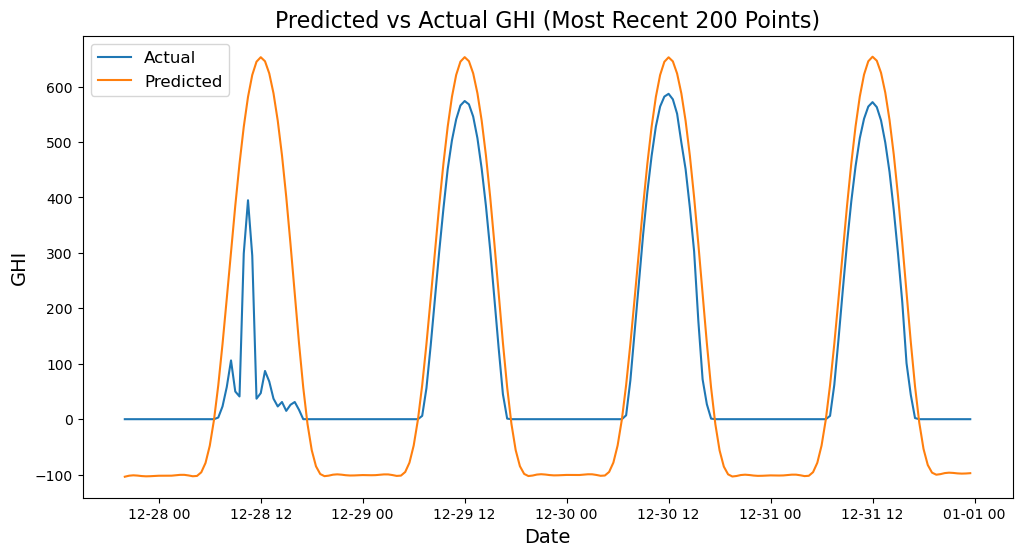

In [20]:
num_dates = 200  # Number of most recent dates to select

# Select the most recent dates and their corresponding values
recent_ghi_forecast = ghi_forecast.tail(num_dates)
recent_test = ghi_test.tail(num_dates)

# Plot the most recent dates
f, ax = plt.subplots(1, figsize=(12, 6))
ax.plot(recent_test['ds'], recent_test['y'], label='Actual')
ax.plot(recent_ghi_forecast['ds'], recent_ghi_forecast['yhat1'], label='Predicted')
ax.set_xlabel('Date', fontsize = 14)
ax.set_ylabel('GHI', fontsize = 14)
ax.set_title('Predicted vs Actual GHI (Most Recent 200 Points)', fontsize = 16)
ax.legend(fontsize = 12)
plt.savefig('../figures/prophet_predactual_recent.png')

**The image above is the most recent 200 points(Approximately 4 days) for the actual and predicted values. These are plotted in a 30 minute time frequency.**

In [21]:
fig = model.plot_components(ghi_forecast)
pio.write_image(fig, '../figures/forecast_component_plots.png')

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [ ]:
#The image for the components plots has to be saved as a static image since Neural Prophet uses plotly, it provides an interactive widget.
#https://plotly.com/python/static-image-export/ thank you Eric for the link.
fig

![The image above shows the components of the forecast.](../figures/forecast_component_plots.png)

**The image above shows the components of the forecast.**

- *Note: This is a static image capture from the plotly widget.  If you area using Neural Prophet with the widget installed you will get an interactive graph that allows you to zoom in and out as well as look at the different date and time ranges for the forecast.*

--- 
### Evaluation Data Where Zenith Angle is Below 90 Degrees

Below we will be filtering the Zenith angle Above 90 degrees and eveluating our metrics based off of that data.

Creating the filter for the testing data. (Based on the GHI units)

In [40]:
sz_test = test['Solar Zenith Angle']
idx_test = np.where(sz_test[sz_test < 90])[0]
y_filt_test = test['GHI'].iloc[idx_test]
preds_filt_test = y_pred_test[idx_test]
rmse_filt_test = mean_squared_error(y_filt_test, preds_filt_test, squared=False)
mae_filt_test = mean_absolute_error(y_filt_test, preds_filt_test)

Creating the filter for the training data. (Based on the GHI units)

In [42]:
sz_train = train['Solar Zenith Angle']
idx_train = np.where(sz_test[sz_test < 90])[0]
y_filt_train = test['GHI'].iloc[idx_train]
preds_filt_train = y_pred_train[idx_train]
rmse_filt_train = mean_squared_error(y_filt_train, preds_filt_train, squared=False)
mae_filt_train = mean_absolute_error(y_filt_train, preds_filt_train)

In [43]:
print("Filtered Root Mean Squared Error (Test):", rmse_filt_test)
print("Filtered Root Mean Squared Error (Training):", rmse_filt_train)

Filtered Root Mean Squared Error (Test): 101.5785555805285
Filtered Root Mean Squared Error (Training): 109.20096101252325


In [44]:
print("Filtered Mean Absolute Error (Test):", mae_filt_test)
print("Filtered Mean Absolute Error (Training):", mae_filt_train)

Filtered Mean Absolute Error (Test): 59.187681492645346
Filtered Mean Absolute Error (Training): 88.67754340606366


Overall it seems like the model is slightly overfit based on the RMSE. This means that the model is performing better on the training data than the test data. Based on the MAE it seems like the model predictions area somewhat deviated from the actual data.  It seems like the filtered evaluation is worse than the regular model evaluation.

---
#### Sources

*Below are some of the sources I used to help set up as well as processing ideas for the neural prophet model.*

[NeuralProphet: A Neural Network based Time-Series Model](https://medium.com/analytics-vidhya/neuralprophet-a-neural-network-based-time-series-model-3c74af3b0ec6)

[Neural Prophet for Time Series](https://www.linkedin.com/pulse/neural-prophet-timeseries-rupak-roy/?utm_source=share&utm_medium=member_ios&utm_campaign=share_via)

[In-Depth Understanding of NeuralProphet through a Complete Example](https://towardsdatascience.com/in-depth-understanding-of-neuralprophet-through-a-complete-example-2474f675bc96)